# Figures 8-11 NHANES I Survival Model

This is a cox proportional hazards model on data from <a href="https://wwwn.cdc.gov/nchs/nhanes/nhanes1">NHANES I</a> with followup mortality data from the <a href="https://wwwn.cdc.gov/nchs/nhanes/nhefs">NHANES I Epidemiologic Followup Study</a>. It is designed to illustrate how through the use of SHAP values we can interpret XGBoost models where traditionally only linear models are used. We see interesting and non-linear patterns in the data, which suggest the potential of this approach. Keep in mind the data has not yet been checked by us for calibrations to current lab tests and so you should not consider this as rock solid medical insights, but rather just as a proof of concept. 

Note that XGBoost only recently got support for a Cox objective, so you will need the most recent version of master.

In [76]:
import pandas as pd
import matplotlib.pyplot as pl
from sklearn.model_selection import train_test_split
import xgboost
import numpy as np
import shap
import scipy as sp
import time

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Create XGBoost data objects

In [77]:
X,y,X_display = shap.datasets.nhanesi()

def sort_data(X, y):
    sinds = np.argsort(np.abs(y))
    return X.iloc[sinds,:],y[sinds]

# create a complete dataset
#X,y = sort_data(X, np.array(y))
xgb_full = xgboost.DMatrix(X, label=y)

# create a train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)
#X_train,y_train = sort_data(X_train, y_train)
xgb_train = xgboost.DMatrix(X_train, label=y_train)
#X_test,y_test = sort_data(X_test, y_test)
xgb_test = xgboost.DMatrix(X_test, label=y_test)





## Train XGBoost model

In [3]:
# use validation set to choose # of trees
# params = {
#     "eta": 0.001,
#     "max_depth": 3,
#     "objective": "survival:cox",
#     "subsample": 0.5
# }
# model_train = xgboost.train(params, xgb_train, 10000, evals = [(xgb_test, "test")], verbose_eval=1000)

In [78]:
# train final model on the full data set
params = {
    "eta": 0.001,
    "max_depth": 3, 
    "objective": "survival:cox",
    "subsample": 0.5
}
model = xgboost.train(params, xgb_full, 7000, evals = [(xgb_full, "test")], verbose_eval=1000)

[0]	test-cox-nloglik:8.88223
[1000]	test-cox-nloglik:8.30451
[2000]	test-cox-nloglik:8.17194
[3000]	test-cox-nloglik:8.11726
[4000]	test-cox-nloglik:8.08533
[5000]	test-cox-nloglik:8.06437
[6000]	test-cox-nloglik:8.04836
[6999]	test-cox-nloglik:8.03541


## Explain the predictions on the entire dataset

In [79]:
shap_values = model.predict(xgb_full, pred_contribs=True)

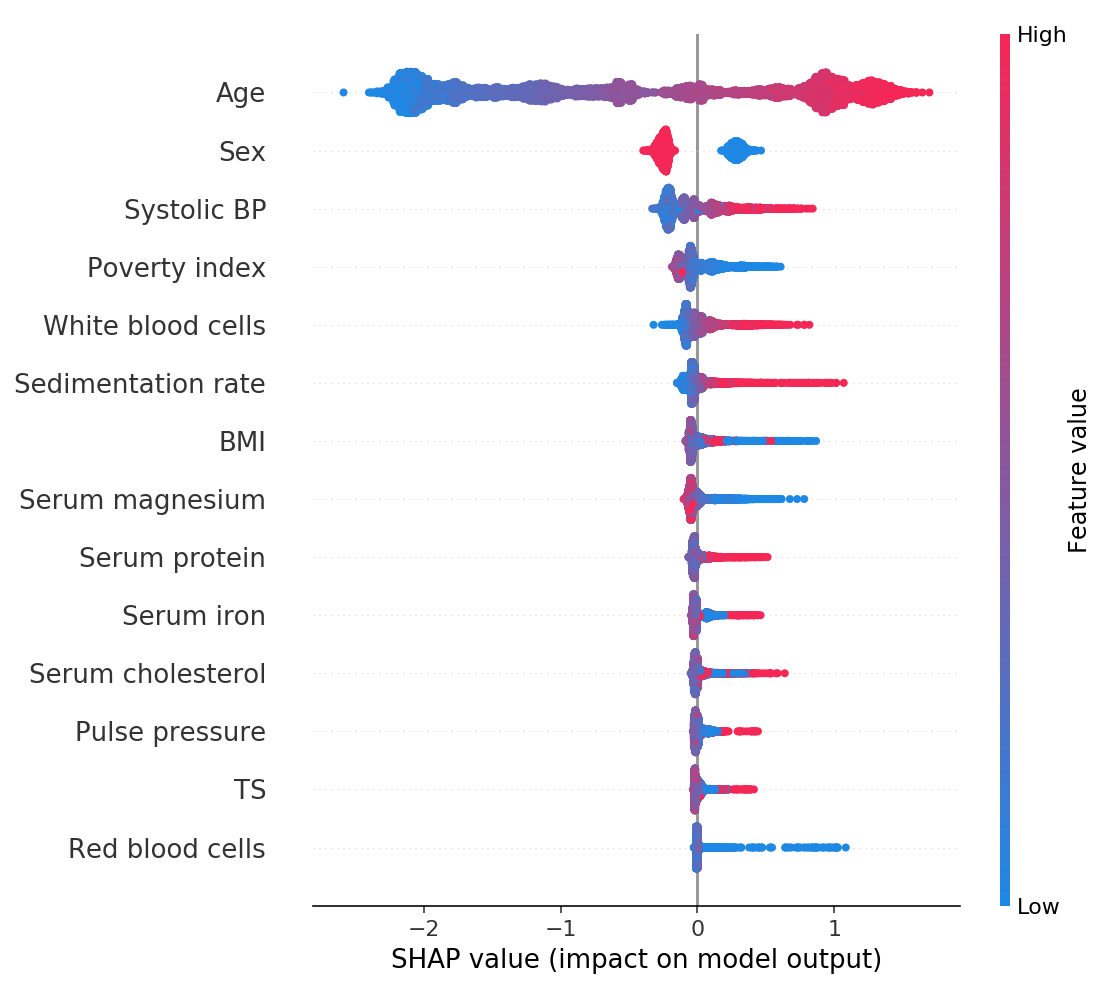

In [114]:
shap.summary_plot(shap_values, X, show=False)
pl.savefig("data/nhanes_summary.pdf", dpi=400)
pl.show()

In [7]:
# shap.summary_plot(shap_values, X, show=False)
# pl.gca().set_rasterized(True)
# pl.savefig("data/nhanes_summary.pdf", dpi=400)

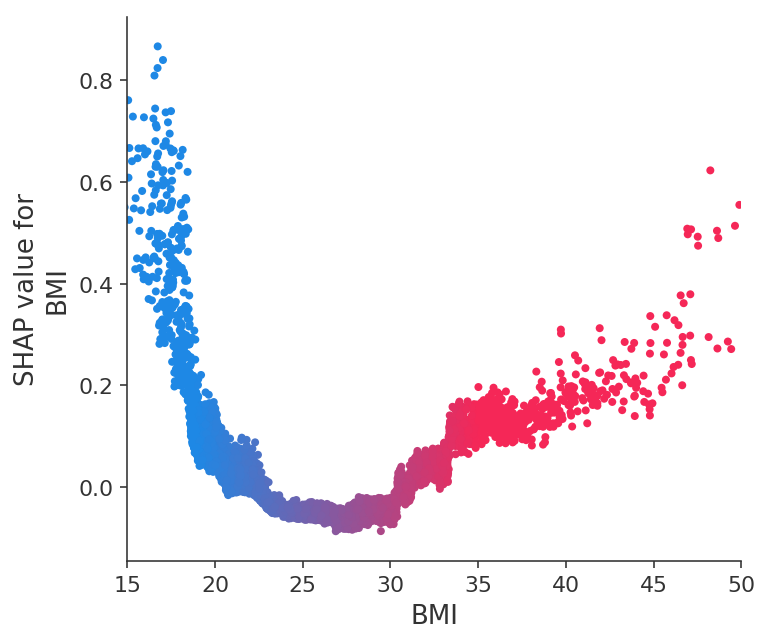

In [81]:
shap.dependence_plot("BMI", shap_values, X, show=False, interaction_index="BMI")
pl.xlim(15,50)
pl.gcf().set_size_inches(5.5, 5)
#pl.savefig("data/nhanes_bmi.pdf")
pl.show()

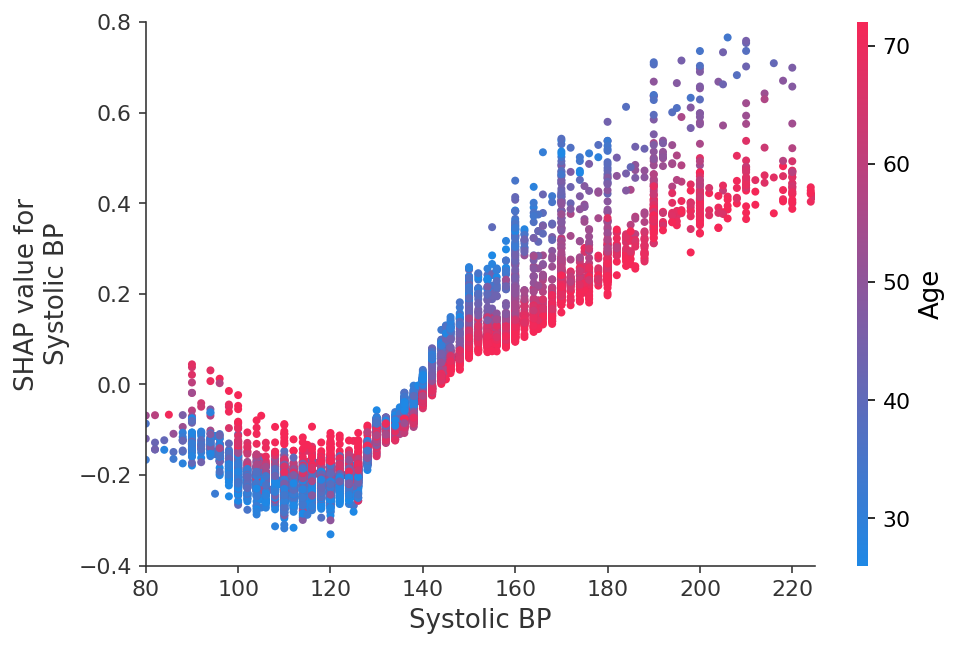

In [102]:
shap.dependence_plot("Systolic BP", shap_values, X, show=False)
pl.xlim(80,225)
pl.ylim(-0.4,0.8)
pl.savefig("data/nhanes_sbp.pdf", dpi=400)
pl.show()

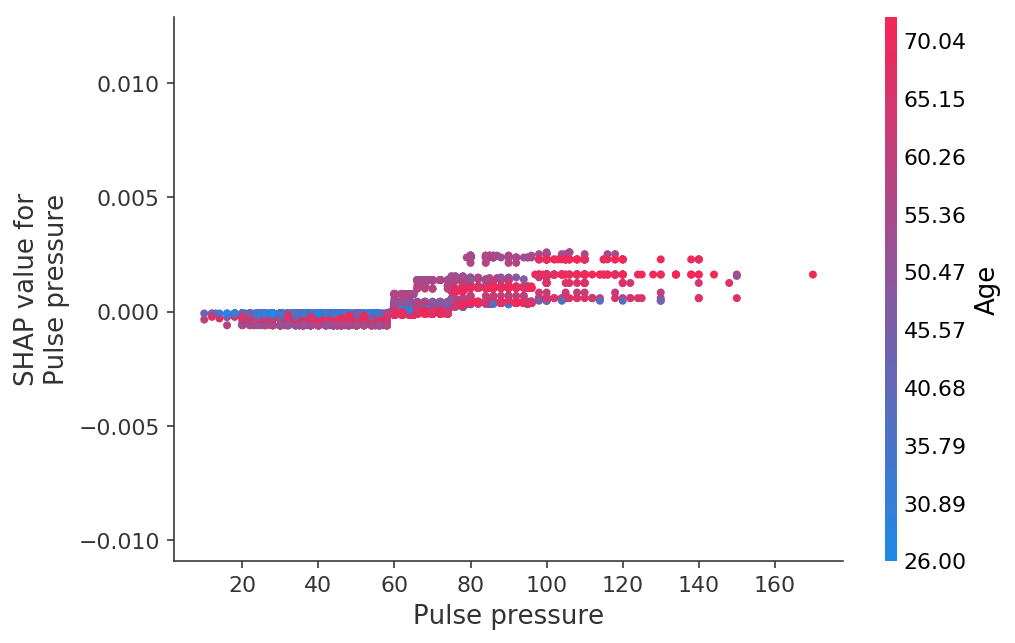

In [7]:
shap.dependence_plot("Pulse pressure", shap_values, X, show=False)
#pl.xlim(80,225)
# pl.savefig("data/nhanes_sbp.pdf")
# pl.show()

## Compute SHAP Interaction Values

In [91]:
start = time.time()
shap_interaction_values = model.predict(xgboost.DMatrix(X.iloc[:,:]), pred_interactions=True)
time.time() - start

1719.4832379817963

In [56]:
np.exp(pred[i]),np.exp(pred[i:]).sum()

(1.5835168, 16780.945)

In [57]:
pred

array([ 0.4273698 ,  0.69642174,  0.69901985, ...,  0.42367142,
        0.50241035,  0.7435447 ], dtype=float32)

In [62]:
?np.sort

[<matplotlib.lines.Line2D at 0x1a27189e48>]

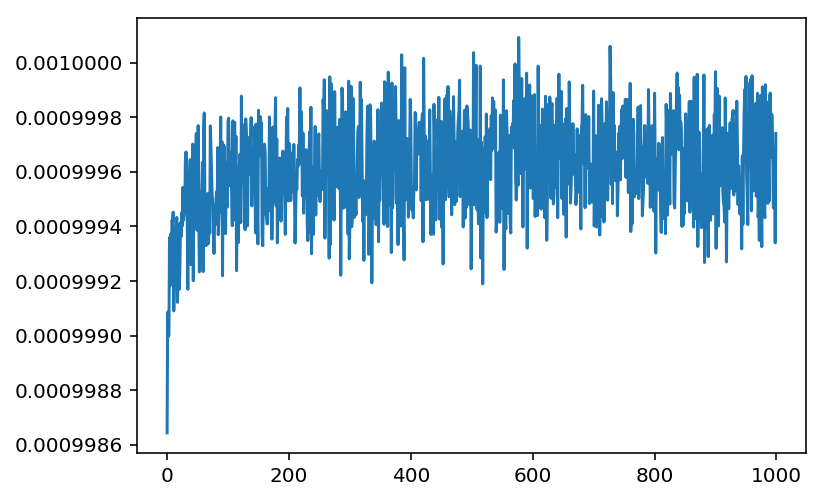

In [75]:
pred = model.predict(xgb_full, output_margin=True)
pred = np.flip(np.sort(pred),axis=0)
C = 0.001
tmp = [np.log(np.exp(pred[i]+C)/(np.exp(pred[i+1:]).sum() + np.exp(pred[i]+C))) - np.log(np.exp(pred[i])/np.exp(pred[i:]).sum()) for i in range(1000)]
pl.plot(tmp)

In [ ]:
def scaled(A, B, C):
    return A*C/(B + A*C)

In [41]:
B = 100
C = 0.01
out = np.zeros(100)
proportion = np.zeros(100)
As = np.linspace(-20,20,100)
for i,A in enumerate(As):
    proportion[i] = np.exp(A)/(B+np.exp(A))
    out[i] = A + C - np.log(B + np.exp(A)*np.exp(C)) - (A - np.log(B + np.exp(A)))

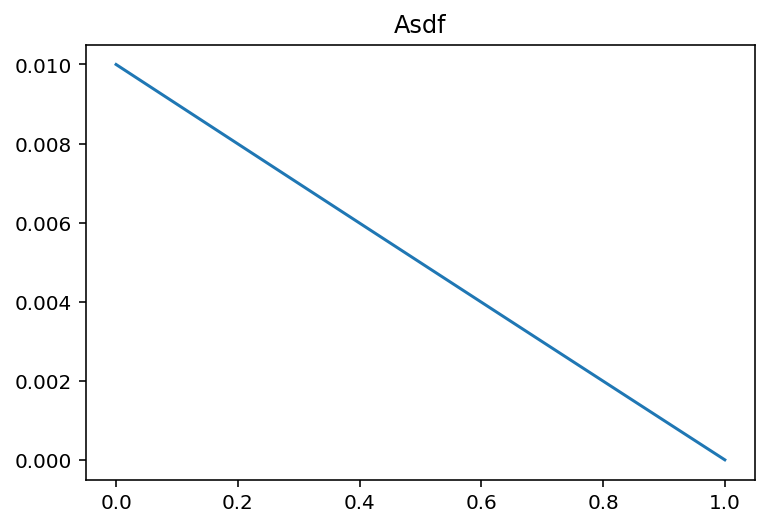

In [42]:
pl.plot(proportion,out)
pl.title("Asdf")

[<matplotlib.lines.Line2D at 0x1a1fbf29e8>]

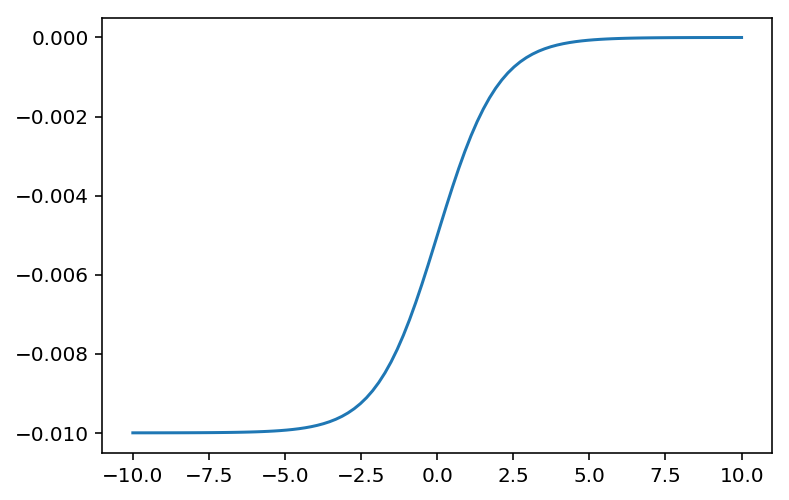

In [43]:
xs = np.linspace(-10,10,100)
pl.plot(xs, np.log(1/(1+np.exp(-xs+C))) - np.log(1/(1+np.exp(-xs))))

In [ ]:
np.log(1) - np.log(1+np.exp(-xs+C))

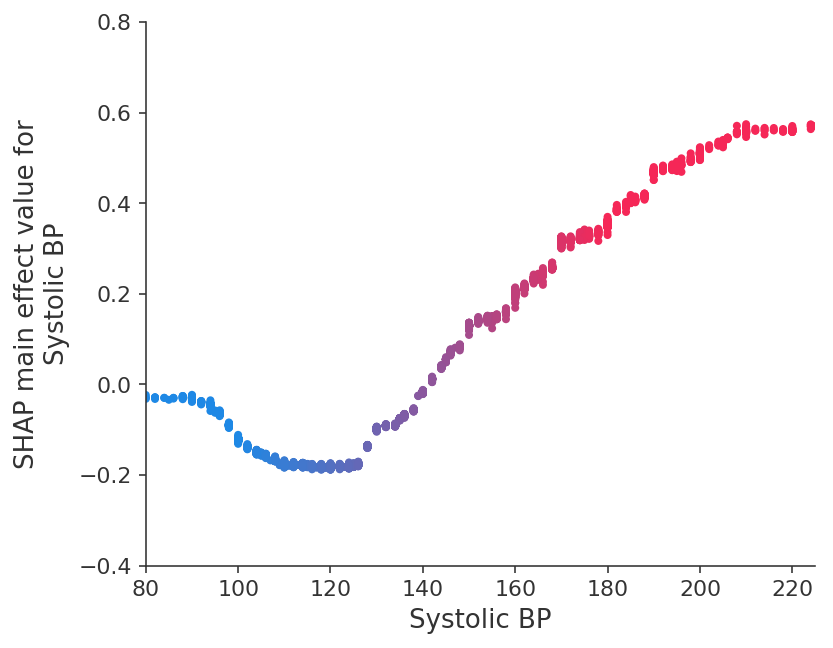

In [104]:
shap.dependence_plot(
    ("Systolic BP", "Systolic BP"),
    shap_interaction_values, X.iloc[:,:],
    display_features=X_display.iloc[:,:],
    show=False
)
pl.xlim(80,225)
pl.ylim(-0.4,0.8)
pl.ylabel("SHAP main effect value for\nSystolic BP")
pl.gcf().set_size_inches(6, 5)
pl.savefig("data/nhanes_sbp_main_effect.pdf", dpi=400)
pl.show()

In [111]:
def dependence_plot2(ind, shap_values, features, feature_names=None, display_features=None,
                    interaction_index="auto", color="#ff0052", axis_color="#333333",
                    dot_size=16, alpha=1, title=None, show=True):
    """
    Create a SHAP dependence plot, colored by an interaction feature.

    Parameters
    ----------
    ind : int
        Index of the feature to plot.

    shap_values : numpy.array
        Matrix of SHAP values (# samples x # features)

    features : numpy.array or pandas.DataFrame
        Matrix of feature values (# samples x # features)

    feature_names : list
        Names of the features (length # features)

    display_features : numpy.array or pandas.DataFrame
        Matrix of feature values for visual display (such as strings instead of coded values)

    interaction_index : "auto", None, or int
        The index of the feature used to color the plot.
    """

    # convert from DataFrames if we got any
    if str(type(features)) == "<class 'pandas.core.frame.DataFrame'>":
        if feature_names is None:
            feature_names = features.columns
        features = features.values
    if str(type(display_features)) == "<class 'pandas.core.frame.DataFrame'>":
        if feature_names is None:
            feature_names = display_features.columns
        display_features = display_features.values
    elif display_features is None:
        display_features = features

    if feature_names is None:
        feature_names = ["Feature "+str(i) for i in range(shap_values.shape[1]-1)]

    # allow vectors to be passed
    if len(shap_values.shape) == 1:
        shap_values = np.reshape(shap_values, len(shap_values), 1)
    if len(features.shape) == 1:
        features = np.reshape(features, len(features), 1)

    def convert_name(ind):
        if type(ind) == str:
            nzinds = np.where(feature_names == ind)[0]
            if len(nzinds) == 0:
                print("Could not find feature named: "+ind)
                return None
            else:
                return nzinds[0]
        else:
            return ind

    ind = convert_name(ind)

    # plotting SHAP interaction values
    if len(shap_values.shape) == 3 and len(ind) == 2:
        ind1 = convert_name(ind[0])
        ind2 = convert_name(ind[1])
        if ind1 == ind2:
            proj_shap_values = shap_values[:,ind2,:]
        else:
            proj_shap_values = shap_values[:,ind2,:] * 2 # off-diag values are split in half
        dependence_plot2(
            ind1, proj_shap_values, features, feature_names=feature_names,
            interaction_index=ind2, display_features=display_features, show=False
        )
        if ind1 == ind2:
            pl.ylabel("SHAP main effect value for\n"+feature_names[ind1])
        else:
            pl.ylabel("SHAP interaction value for\n"+feature_names[ind1]+" and "+feature_names[ind2])

        if show:
            pl.show()
        return

    # get both the raw and display feature values
    xv = features[:,ind]
    xd = display_features[:,ind]
    s = shap_values[:,ind]
    if type(xd[0]) == str:
        name_map = {}
        for i in range(len(xv)):
            name_map[xd[i]] = xv[i]
        xnames = list(name_map.keys())

    # allow a single feature name to be passed alone
    if type(feature_names) == str:
        feature_names = [feature_names]
    name = feature_names[ind]

    # guess what other feature as the stongest interaction with the plotted feature
    if interaction_index == "auto":
        interaction_index = approx_interactions(ind, shap_values, features)[0]
    interaction_index = convert_name(interaction_index)

    # get both the raw and display color values
    cv = features[:,interaction_index]
    cd = display_features[:,interaction_index]
    categorical_interaction = False
    clow = np.nanpercentile(features[:,interaction_index], 5)
    chigh = np.nanpercentile(features[:,interaction_index], 95)
    if type(cd[0]) == str:
        cname_map = {}
        for i in range(len(cv)):
            cname_map[cd[i]] = cv[i]
        cnames = list(cname_map.keys())
        categorical_interaction = True
    elif clow % 1 == 0 and chigh % 1 == 0 and len(set(features[:,interaction_index])) < 50:
        categorical_interaction = True

    # discritize colors for categorical features
    color_norm = None
    if categorical_interaction and clow != chigh:
        bounds = np.linspace(clow, chigh, chigh-clow+2)
        color_norm = matplotlib.colors.BoundaryNorm(bounds, red_blue.N)

    # the actual scatter plot, TODO: adapt the dot_size to the number of data points?
    pl.scatter(xv, s, s=dot_size, linewidth=0, c="#1E88E5",
               alpha=alpha, rasterized=len(xv) > 500)

    if interaction_index != ind:
        # draw the color bar
        norm = None
        if type(cd[0]) == str:
            tick_positions = [cname_map[n] for n in cnames]
            if len(tick_positions) == 2:
                tick_positions[0] -= 0.25
                tick_positions[1] += 0.25
            cb = pl.colorbar(ticks=tick_positions)
            cb.set_ticklabels(cnames)

        else:
            cb = pl.colorbar()
        cb.set_label(feature_names[interaction_index], size=13)
        cb.ax.tick_params(labelsize=11)
        if categorical_interaction:
            cb.ax.tick_params(length=0)
        cb.set_alpha(1)
        cb.outline.set_visible(False)
        bbox = cb.ax.get_window_extent().transformed(pl.gcf().dpi_scale_trans.inverted())
        cb.ax.set_aspect((bbox.height-0.7)*20)

    # make the plot more readable
    if interaction_index != ind:
        pl.gcf().set_size_inches(7.5, 5)
    else:
        pl.gcf().set_size_inches(6, 5)
    pl.xlabel(name, color=axis_color, fontsize=13)
    pl.ylabel("SHAP value for\n"+name, color=axis_color, fontsize=13)
    if title != None:
        pl.title(title, color=axis_color, fontsize=13)
    pl.gca().xaxis.set_ticks_position('bottom')
    pl.gca().yaxis.set_ticks_position('left')
    pl.gca().spines['right'].set_visible(False)
    pl.gca().spines['top'].set_visible(False)
    pl.gca().tick_params(color=axis_color, labelcolor=axis_color, labelsize=11)
    for spine in pl.gca().spines.values():
        spine.set_edgecolor(axis_color)
    if type(xd[0]) == str:
        pl.xticks([name_map[n] for n in xnames], xnames, rotation='vertical', fontsize=11)
    if show:
        pl.show()


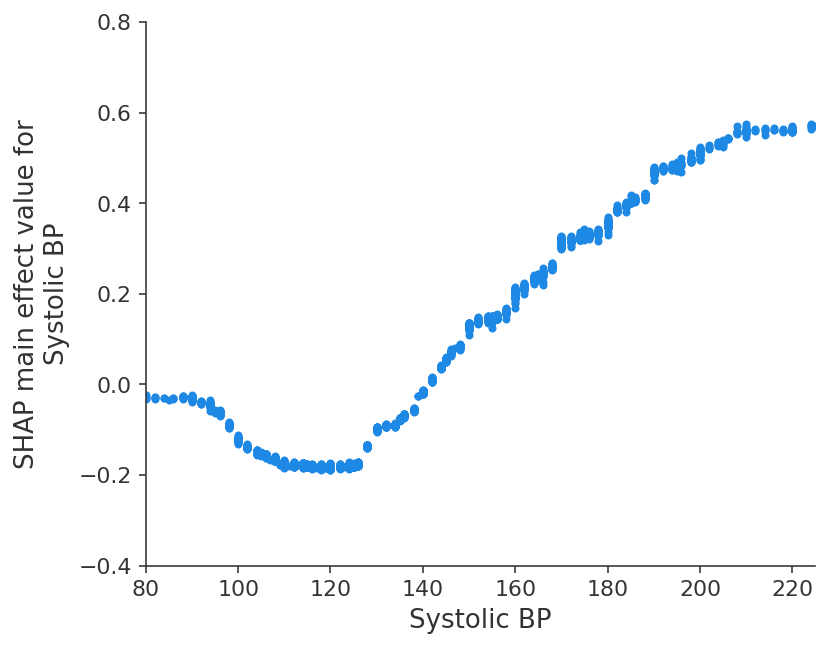

In [112]:
dependence_plot2(
    ("Systolic BP", "Systolic BP"),
    shap_interaction_values, X.iloc[:,:],
    display_features=X_display.iloc[:,:],
    show=False
)
pl.xlim(80,225)
pl.ylim(-0.4,0.8)
pl.ylabel("SHAP main effect value for\nSystolic BP")
pl.gcf().set_size_inches(6, 5)
pl.savefig("data/nhanes_sbp_main_effect.pdf", dpi=400)
pl.show()

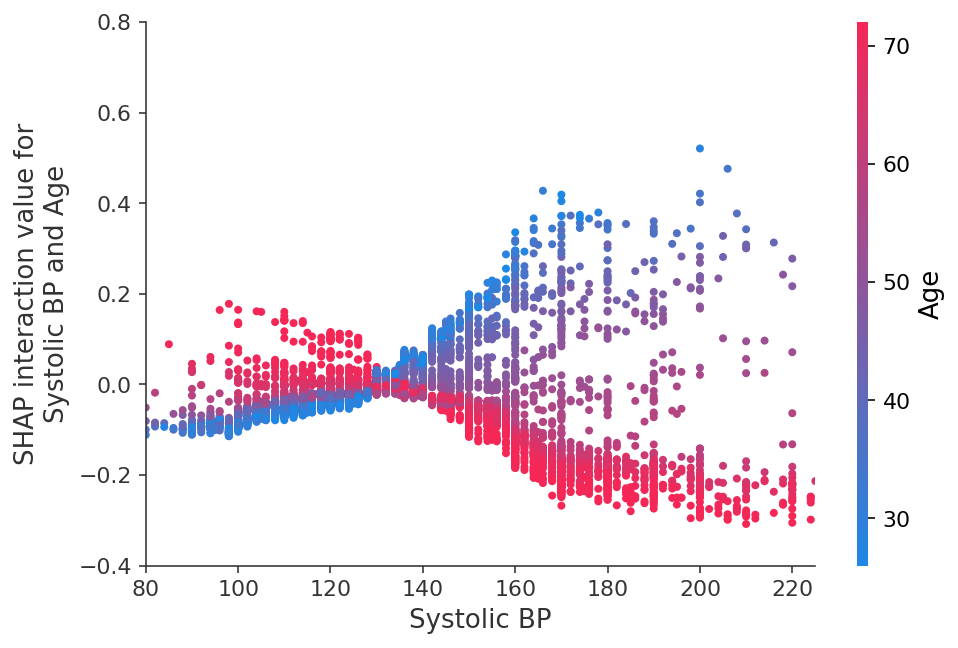

In [100]:
shap.dependence_plot(
    ("Systolic BP", "Age"),
    shap_interaction_values, X.iloc[:,:],
    display_features=X_display.iloc[:,:],
    show=False
)
pl.xlim(80,225)
pl.ylim(-0.4,0.8)
pl.savefig("data/nhanes_sbp_age_interaction.pdf", dpi=400)
pl.show()

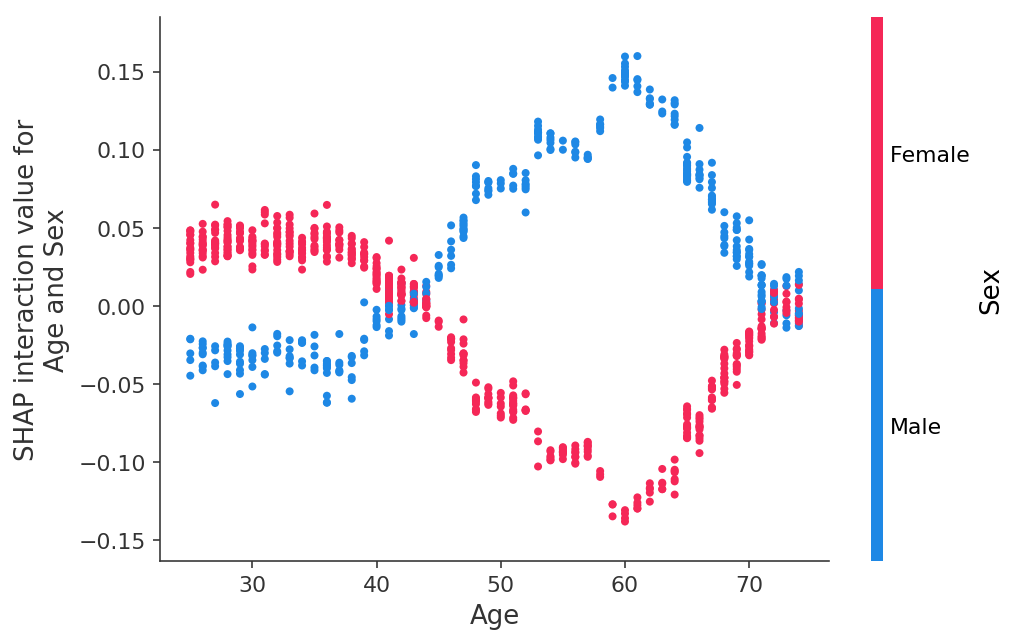

In [5]:
shap.dependence_plot(
    ("Age", "Sex"),
    shap_interaction_values, X.iloc[:1000,:],
    display_features=X_display.iloc[:1000,:]
)

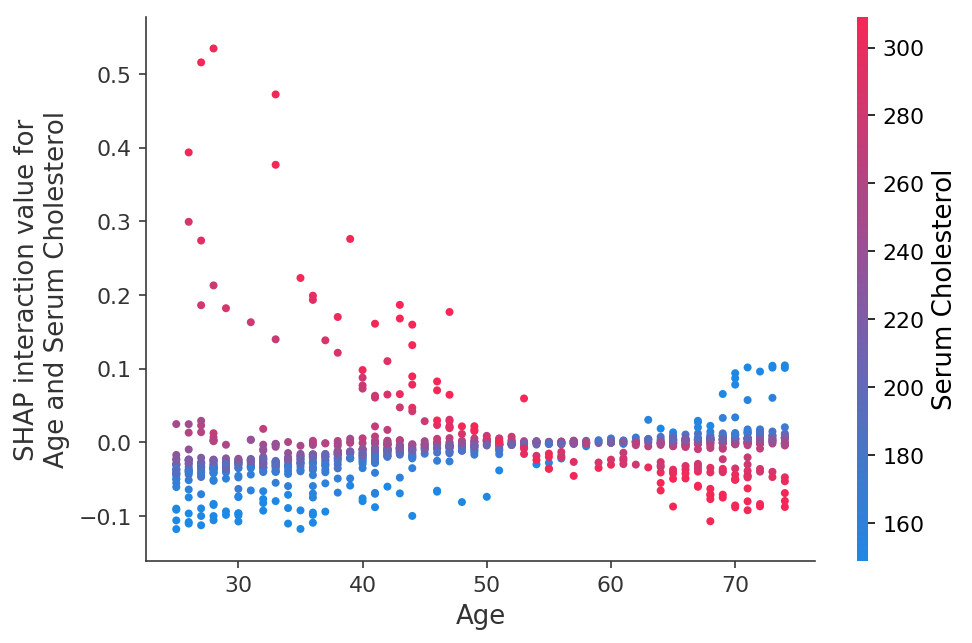

In [56]:
shap.dependence_plot(0, shap_interaction_values[:,4,:], X.iloc[:1000,:], interaction_index=4, show=False)
pl.ylabel("SHAP interaction value for\nAge and Serum Cholesterol")
pl.show()

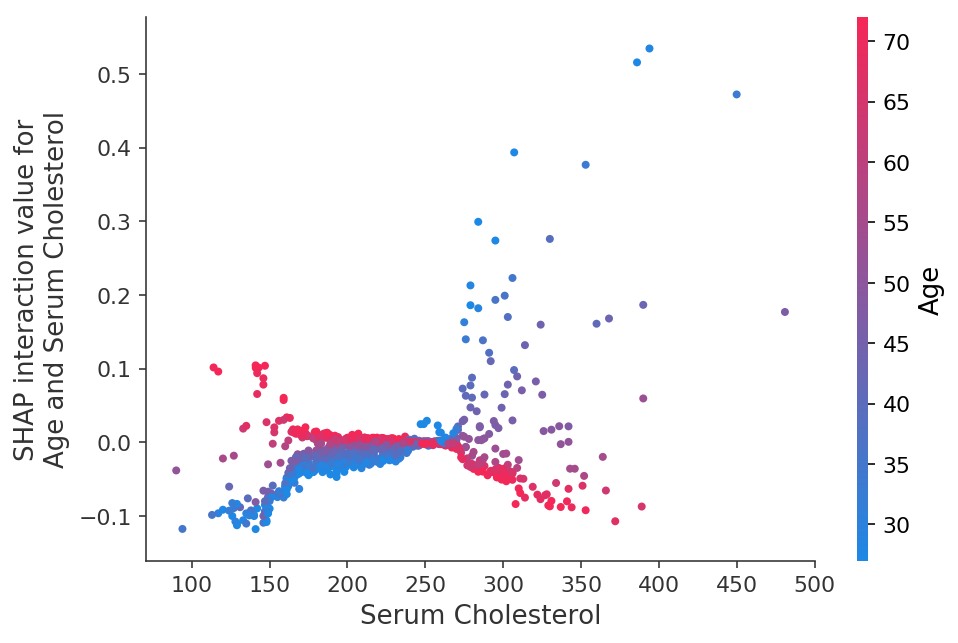

In [58]:
shap.dependence_plot(4, shap_interaction_values[:,0,:], X.iloc[:1000,:], interaction_index=0, show=False)
pl.ylabel("SHAP interaction value for\nAge and Serum Cholesterol")
pl.show()

In [37]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

shap_pca2 = PCA(n_components=2).fit_transform(shap_values[:,:-1])

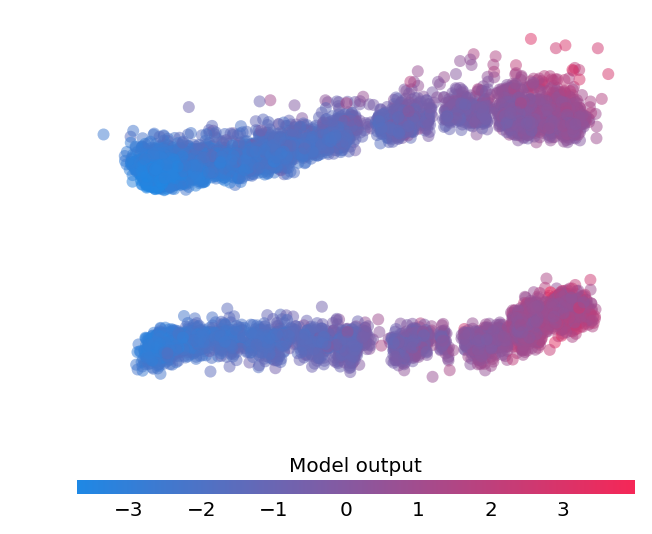

In [13]:
f = pl.figure(figsize=(5,5))
pl.scatter(shap_pca2[:,0], shap_pca2[:,1], c=np.sum(shap_values,axis=1), linewidth=0, alpha=0.5, cmap=shap.plots.red_blue)
cb = pl.colorbar(label="Model output", aspect=40, orientation="horizontal")
cb.set_alpha(1)
cb.draw_all()
cb.outline.set_linewidth(0)
cb.ax.tick_params('x', length=0)
cb.ax.xaxis.set_label_position('top')
pl.gca().axis("off")
pl.show()

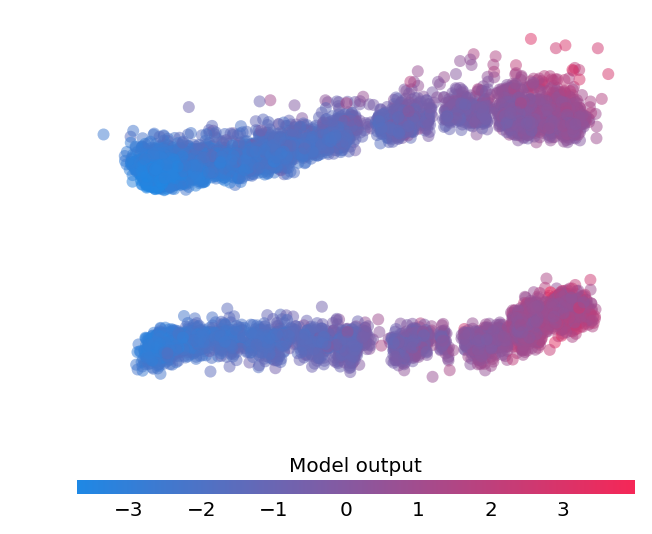

In [13]:
f = pl.figure(figsize=(5,5))
pl.scatter(shap_pca2[:,0], shap_pca2[:,1], c=np.sum(shap_values,axis=1), linewidth=0, alpha=0.5, cmap=shap.plots.red_blue)
cb = pl.colorbar(label="Model output", aspect=40, orientation="horizontal")
cb.set_alpha(1)
cb.draw_all()
cb.outline.set_linewidth(0)
cb.ax.tick_params('x', length=0)
cb.ax.xaxis.set_label_position('top')
pl.gca().axis("off")
pl.show()

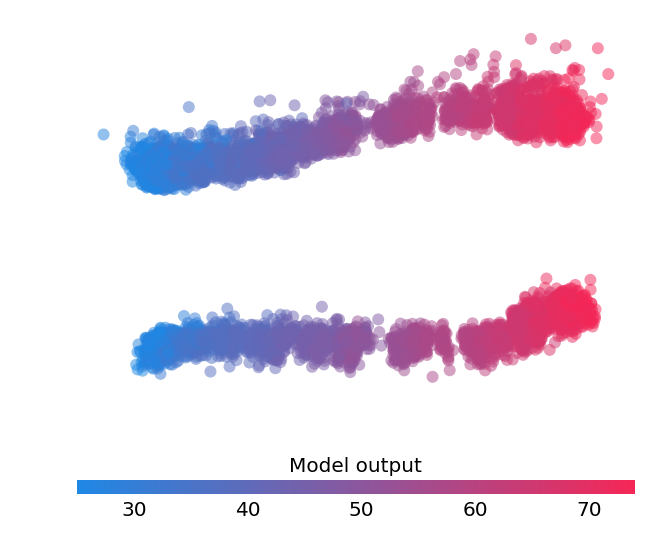

In [23]:
f = pl.figure(figsize=(5,5))
pl.scatter(shap_pca2[:,0], shap_pca2[:,1], c=X["Age"], linewidth=0, alpha=0.5, cmap=shap.plots.red_blue)
cb = pl.colorbar(label="Model output", aspect=40, orientation="horizontal")
cb.set_alpha(1)
cb.draw_all()
cb.outline.set_linewidth(0)
cb.ax.tick_params('x', length=0)
cb.ax.xaxis.set_label_position('top')
pl.gca().axis("off")
pl.show()

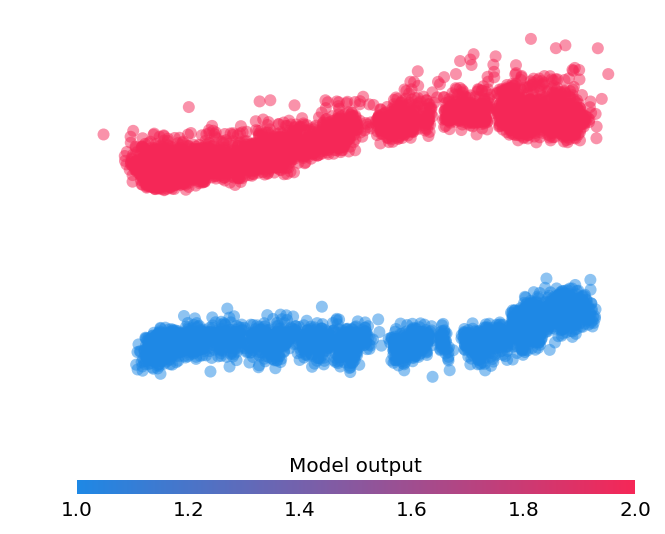

In [24]:
f = pl.figure(figsize=(5,5))
pl.scatter(shap_pca2[:,0], shap_pca2[:,1], c=X["Sex"], linewidth=0, alpha=0.5, cmap=shap.plots.red_blue)
cb = pl.colorbar(label="Model output", aspect=40, orientation="horizontal")
cb.set_alpha(1)
cb.draw_all()
cb.outline.set_linewidth(0)
cb.ax.tick_params('x', length=0)
cb.ax.xaxis.set_label_position('top')
pl.gca().axis("off")
pl.show()

In [15]:
shap_pca2 = PCA(n_components=2).fit(shap_values[:,:-1])

In [17]:
?shap_pca2

In [19]:
shap_pca2.components_.round(2)

array([[ 1.        ,  0.01      ,  0.        ,  0.01      ,  0.        ,
        -0.        ,  0.        ,  0.        ,  0.04      ,  0.07      ,
        -0.        , -0.        , -0.        , -0.        ],
       [ 0.03      ,  0.05      ,  0.01      ,  0.09      ,  0.        ,
         0.01      ,  0.03      ,  0.        , -0.99000001,  0.02      ,
         0.01      , -0.02      ,  0.05      ,  0.01      ]], dtype=float32)

In [39]:
shap_embedded = TSNE(n_components=2, perplexity=50).fit_transform(shap_values[:1000,:-1])

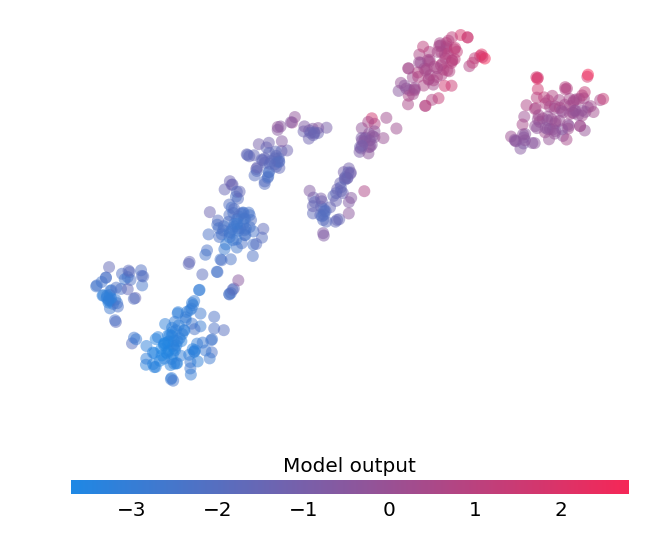

In [32]:
f = pl.figure(figsize=(5,5))
pl.scatter(shap_embedded[:,0], shap_embedded[:,1], c=np.sum(shap_values[:1000,:],axis=1), linewidth=0, alpha=0.5, cmap=shap.plots.red_blue)
cb = pl.colorbar(label="Model output", aspect=40, orientation="horizontal")
cb.set_alpha(1)
cb.draw_all()
cb.outline.set_linewidth(0)
cb.ax.tick_params('x', length=0)
cb.ax.xaxis.set_label_position('top')
pl.gca().axis("off")
pl.show()

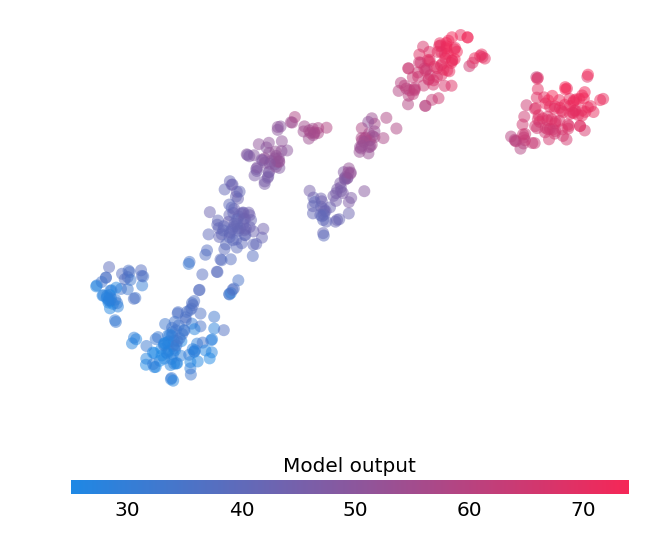

In [34]:
f = pl.figure(figsize=(5,5))
pl.scatter(shap_embedded[:,0], shap_embedded[:,1], c=X["Age"][:1000], linewidth=0, alpha=0.5, cmap=shap.plots.red_blue)
cb = pl.colorbar(label="Model output", aspect=40, orientation="horizontal")
cb.set_alpha(1)
cb.draw_all()
cb.outline.set_linewidth(0)
cb.ax.tick_params('x', length=0)
cb.ax.xaxis.set_label_position('top')
pl.gca().axis("off")
pl.show()

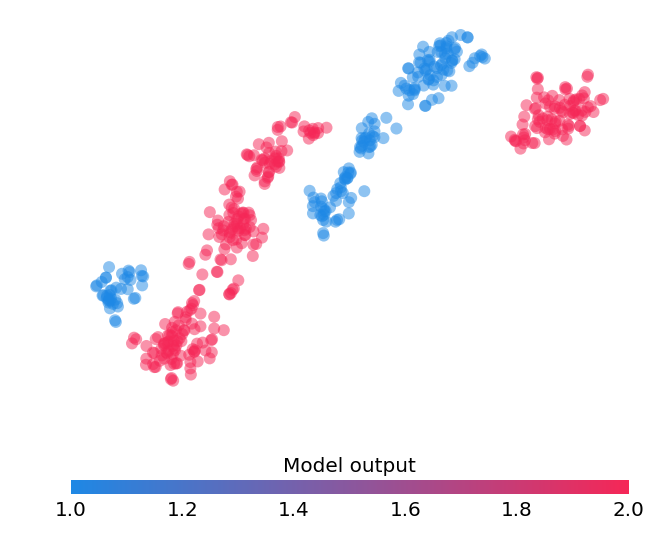

In [35]:
f = pl.figure(figsize=(5,5))
pl.scatter(shap_embedded[:,0], shap_embedded[:,1], c=X["Sex"][:500], linewidth=0, alpha=0.5, cmap=shap.plots.red_blue)
cb = pl.colorbar(label="Model output", aspect=40, orientation="horizontal")
cb.set_alpha(1)
cb.draw_all()
cb.outline.set_linewidth(0)
cb.ax.tick_params('x', length=0)
cb.ax.xaxis.set_label_position('top')
pl.gca().axis("off")
pl.show()

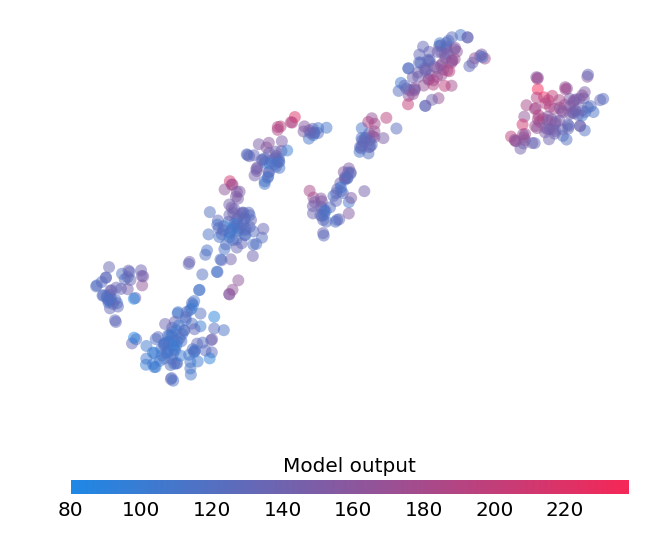

In [36]:
f = pl.figure(figsize=(5,5))
pl.scatter(shap_embedded[:,0], shap_embedded[:,1], c=X["Systolic BP"][:500], linewidth=0, alpha=0.5, cmap=shap.plots.red_blue)
cb = pl.colorbar(label="Model output", aspect=40, orientation="horizontal")
cb.set_alpha(1)
cb.draw_all()
cb.outline.set_linewidth(0)
cb.ax.tick_params('x', length=0)
cb.ax.xaxis.set_label_position('top')
pl.gca().axis("off")
pl.show()

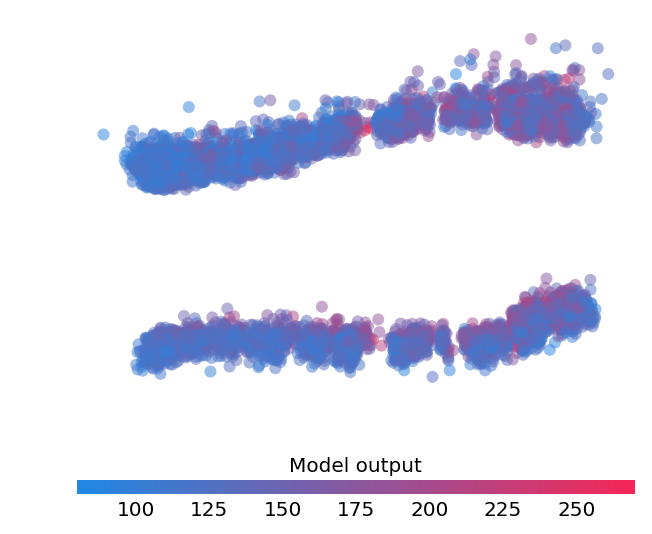

In [38]:
f = pl.figure(figsize=(5,5))
pl.scatter(shap_pca2[:,0], shap_pca2[:,1], c=X["Systolic BP"], linewidth=0, alpha=0.5, cmap=shap.plots.red_blue)
cb = pl.colorbar(label="Model output", aspect=40, orientation="horizontal")
cb.set_alpha(1)
cb.draw_all()
cb.outline.set_linewidth(0)
cb.ax.tick_params('x', length=0)
cb.ax.xaxis.set_label_position('top')
pl.gca().axis("off")
pl.show()